In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import neuralGrU
from GrU import (evaluate, GrU)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [3]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Grid Price

### Shift Grid Prices

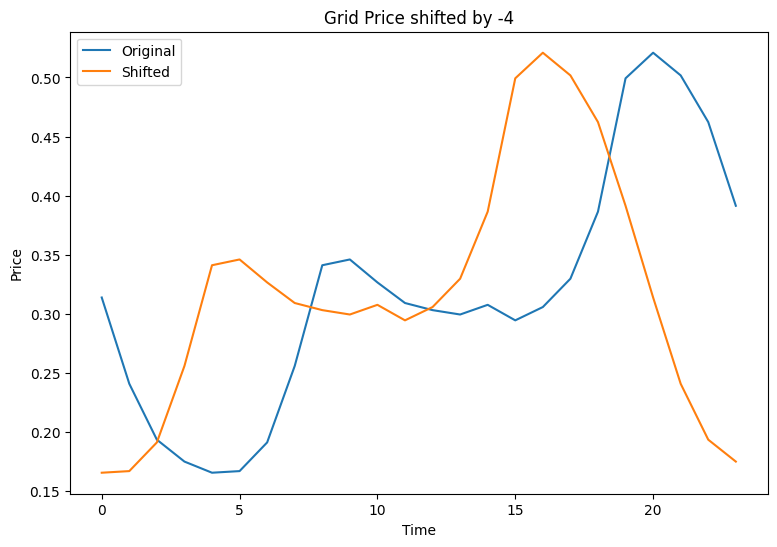

In [27]:
pi_g = getPriceVectors(100)[0]
pi_g_shifted = np.roll(pi_g, shift=-4)

plt.figure(figsize=(9,6))
plt.title('Grid Price shifted by -4')
plt.plot(pi_g, label='Original')
plt.plot(pi_g_shifted, label='Shifted')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()


In [11]:
# EI values
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep = np.array(ep) * 1e3

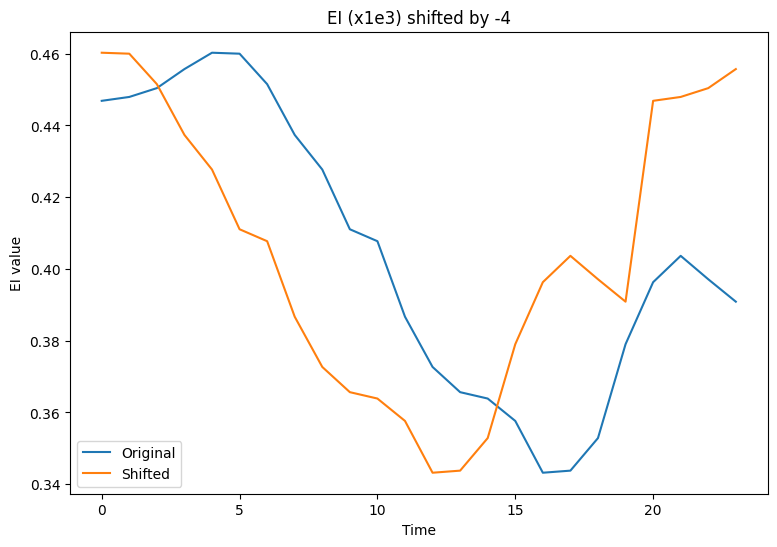

In [28]:
ep_shifted = np.roll(ep, shift=-4)

plt.figure(figsize=(9,6))
plt.title('EI (x1e3) shifted by -4')
plt.plot(ep, label='Original')
plt.plot(ep_shifted, label='Shifted')
plt.ylabel('EI value')
plt.xlabel('Time')
plt.legend()
plt.show()

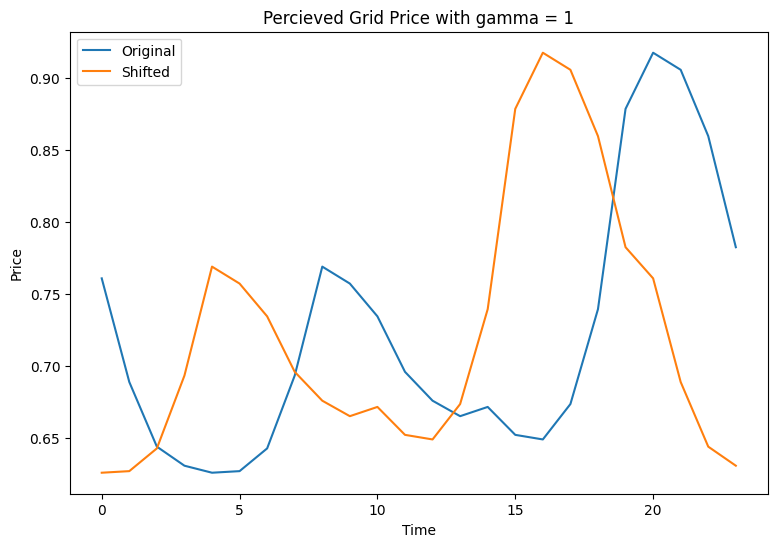

In [29]:
gamma = 1
cost = pi_g + ep * gamma
cost_shifted = pi_g_shifted + ep_shifted * gamma

plt.figure(figsize=(9,6))
plt.title(f'Percieved Grid Price with gamma = {gamma}')
plt.plot( cost, label='Original')
plt.plot( cost_shifted, label='Shifted' )
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

### Non-Linear Min-Max Scaling

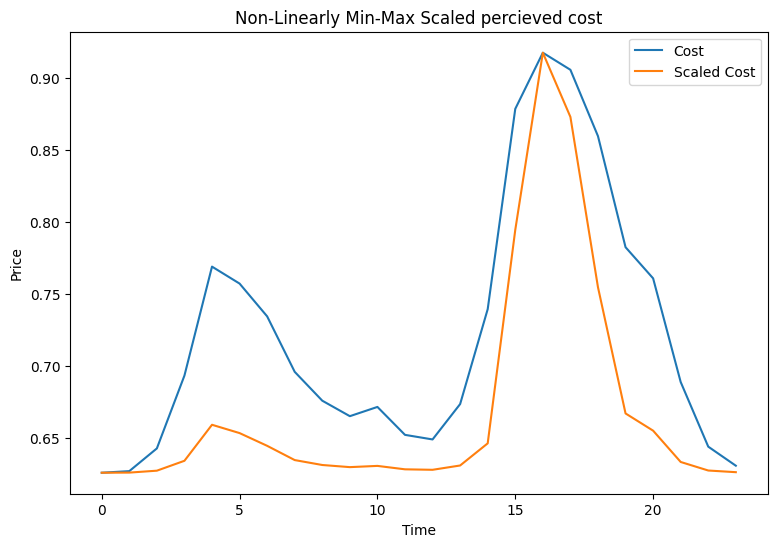

In [30]:
def squash( a, scale = 2 ):
    m = min( a )
    M = max( a )

    p = np.exp( -scale )
    P = np.exp( scale )

    n = (a - m)/(M-m) * 2 * scale
    n = np.exp( n - scale )

    return (n - p) / (P - p) * (M - m) + m

plt.figure(figsize=(9,6))
plt.title('Non-Linearly Min-Max Scaled percieved cost')
plt.plot( cost_shifted, label='Cost' )
plt.plot( squash( cost_shifted, scale = 2 ), label='Scaled Cost' )
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

# Demand breakup on Shifted & Scaled Grid Prices

In [48]:
eta = 1
B = 1e3
alpha = 1e3
n_agents = 1
ep = np.ones(24)

# model = neuralGrU(B, n_agents, ep, [0], device, eta, eta)

In [52]:
prices = getPriceVectors(100)
d_total = np.ones(24) * 2

d_old, _ = GrU(d_total, prices, eta_c=eta, eta_d=eta)

prices[source.grid] = squash(np.roll(prices[source.grid], shift=-4), scale=2)
d_new, _ = GrU(d_total, prices, eta_c=eta, eta_d=eta)

In [53]:
d_old

array([[ 2.,  2., 36.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 34., 34., 34., 34., 34., 32., 30., 28., 26., 24., 22.,
        20., 18., 16., 14., 12., 10.,  8.,  6.,  4.,  2.,  0.],
       [ 0.,  0., 34.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.]])

In [54]:
d_new

array([[ 2.,  8.,  2.,  2.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2., 12.,
         2.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  6.,  6.,  6.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  0., 10.,
        10.,  8.,  6.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.]])